---
bibliography: bibliography.bib

---

# Homophily and attributes analysis
## Introduction

One purpose of this project was to focus on the analysis of how connected actors could be influenced to play in the same movie based on their distinguished attributes. In other words, does "similar" actors are more likely connected into same movies. We need therefore a definition of the similarity. According to several papers, one main tool to assess the similarity is called the homophily. It is the tendency for people to be attracted to those who seems similar to themselves. 

Knowing that we are working on a dataset of actor who are linked between each other through movies, we decided to consider only actors with a minimum degree of fifteen (which is quiet representative to movies in general as the movie story is based on interaction between a quiet large number of characters). Moreover, we also took our decision because low degree vertices shall add some unmeaningful values, particularly for categorical attribute (which can even become binary for very low link degree).

In [158]:
#| echo: false
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import igraph as ig
from scipy import stats
from scipy.stats import t
import plotly.graph_objs as go
import seaborn as sns
from random import sample
import plotly.express as px

import sys
sys.path.append('../src')
from utils import autoparse_year

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [159]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")

In [160]:
#| echo: false
df_edges = pd.read_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

In [161]:
#| echo: false
#| output: false
x=df_edges.rename(columns={"actor2_fbid": "actor1_fbid","actor1_fbid": "actor2_fbid"})
df_edges= pd.concat([df_edges, x])
df_edges

,actor1_fbid,actor2_fbid,movie_count
503641,/m/02cvp8,/m/02t0n9,219
503751,/m/02cvp8,/m/045g4l,119
655469,/m/02t0n9,/m/045g4l,119
906958,/m/03mv0b,/m/0lh0c,101
503672,/m/02cvp8,/m/030dx5,82
...,...,...,...
717944,/m/09t0l3,/m/02z28y7,1
717943,/m/09rxk8z,/m/02z28y7,1
717942,/m/09rvxt5,/m/02z28y7,1
717941,/m/09q3gc,/m/02z28y7,1


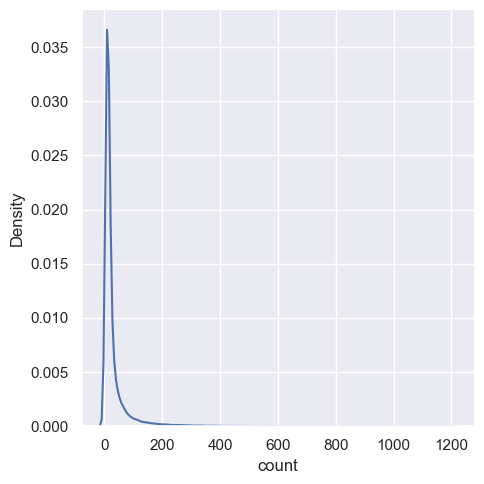

In [162]:
#| echo: false
#| output: false
test =df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count']).sort_values(by='count')
test2 = test[test['count'] > 3]
sns.displot(test, x="count", kind="kde")

In [163]:
#| echo: false
df_edges= df_edges[df_edges.apply(lambda x: True if test.loc[x.actor1_fbid]['count']> 15 else False, axis =1)]

In [164]:
#| echo: false
#| output: false
df_actors['year_of_birth'] = df_actors.actor_birth.apply(autoparse_year).astype('Int64')
df_actors=df_actors.rename(columns={"fb_actor_id": "actor1_fbid"})
df_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,actor1_fbid,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
1,24767455,/m/0809s7n,2009-10-16,Captain Diaz,51.0,/m/08d9z0b,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
2,5337169,/m/0dg7mt,2001,NaN,42.0,/m/04htxdc,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
3,1330220,/m/04t8wq,1990-06-22,NaN,31.0,/m/0cg7kl2,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
4,14686017,/m/03gt21w,1990-01-12,NaN,31.0,/m/09j0r8t,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Additional Voices,38.0,/m/0kr405f,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450665,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,38.0,/m/0kr407w,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450666,913762,/m/03pcrp,1992-05-21,Silvie Gena,34.0,/m/0kr40b9,/m/0gn4nd,Susan Byrkett,1958,NaN,NaN,F,NaN,1958
450667,913762,/m/03pcrp,1992-05-21,Exegran,NaN,/m/0kr407c,/m/0kr407h,Hal Cleaveland,NaN,NaN,NaN,M,NaN,<NA>


In [165]:
#| echo: false
#| output: false
df_actors_reduced= df_actors.drop_duplicates(subset= 'actor1_fbid')
df_actors_reduced= df_actors_reduced.drop(['wiki_id','fb_movie_id','release','character_name','fb_char_id','actor_birth'], axis=1)
group_by_degree = df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count'])
df_degree = pd.DataFrame({'actor_degree': list(group_by_degree['count']), 'actor1_fbid': group_by_degree.index})
df_actors_reduced= df_actors_reduced.merge(df_degree, on= 'actor1_fbid')
df_actors_reduced= pd.merge(df_actors_reduced, (df_actors.groupby('actor1_fbid').apply(lambda x: pd.Series({
        'number_of_movies': x['wiki_id'].count()
    }))),on='actor1_fbid')
df_edges_merged= df_edges.merge(df_actors_reduced,
                                 on='actor1_fbid').merge(df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"}), on='actor2_fbid')
df_edges_merged

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,...,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,actor_degree_y,number_of_movies_y
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,...,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,...,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,...,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,...,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,...,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036589,/m/0crc1n7,/m/02y_r9n,3,28.0,S. Shamsuddin,NaN,NaN,M,Singapore,1929,...,5,60.0,Aziz Sattar,NaN,NaN,M,Malaysia,1925,17,7
3036590,/m/02f27,/m/0gcb2b4,1,61.0,Dirk Benedict,NaN,1.800,M,United States of America,1945,...,16,NaN,Eike Becker,NaN,NaN,M,NaN,<NA>,19,2
3036591,/m/03qp512,/m/02pyhqk,1,27.0,Peter Lee Lawrence,NaN,NaN,M,West Germany,1945,...,5,29.0,Steve Sipek,NaN,NaN,M,Canada,1942,16,2
3036592,/m/03cx_n5,/m/0gc6ycx,1,NaN,Joel Hoffman,NaN,NaN,M,NaN,<NA>,...,3,NaN,Courtney Lercara,NaN,NaN,F,NaN,<NA>,18,2


In [166]:
#| echo: false
df_edges_gender=df_edges_merged.dropna(subset=['actor_gender_x'])
df_edges_gender=df_edges_gender.dropna(subset=['actor_gender_y'])

df_edges_nat=df_edges_merged.dropna(subset=['actor_nationality_x'])
df_edges_nat=df_edges_nat.dropna(subset=['actor_nationality_y'])


df_edges_birth=df_edges_merged.dropna(subset=['year_of_birth_x'])
df_edges_birth=df_edges_birth.dropna(subset=['year_of_birth_y'])
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_x'] < 2022]
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_y'] < 2022]
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_x']>1800]
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_y']>1800]
std_yob = df_edges_birth.apply(lambda x : abs(x.year_of_birth_x-x.year_of_birth_y),axis=1).std()

df_edges_height=df_edges_merged.dropna(subset=['actor_height_x'])
df_edges_height= df_edges_height.dropna(subset=['actor_height_y'])
df_edges_height=df_edges_height[df_edges_height['actor_height_x']<3]
df_edges_height=df_edges_height[df_edges_height['actor_height_y']<3]
std_height = df_edges_height.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.actor_height_x),axis=1).std()

df_edges_nbr_movies=df_edges_merged.dropna(subset=['number_of_movies_x'])
df_edges_nbr_movies= df_edges_nbr_movies.dropna(subset=['number_of_movies_y'])
std_nbr_movies = df_edges_nbr_movies.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.number_of_movies_x),axis=1).std()

First of all, we know that we will based our study on the attributes of each actors of the dataset. Then, as a data scientist, we need to begin our analysis by quantify each attributes among the different actors and observe the repartition over the dataset.

- For the actor nationality, we have the following interactive plot. We observe a majority (around 45%) of american actors, followed by some country like Canada, India, Great britain, ... We need to keep this distribution in mind for the rest of our study, especially for the comparison part.

In [167]:
#| echo: false
visualization_nat= df_edges_nat.drop_duplicates(subset= "actor1_fbid").groupby('actor_nationality_x')['actor2_fbid'].agg(['count'])
visualization_nat['country']= visualization_nat.index
visualization_nat= visualization_nat.reset_index(drop= True)
choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locations':visualization_nat['country'],
        'locationmode':'country names',
        'colorscale':'Portland',
        'z':visualization_nat['count'],
        'colorbar':{'title':'Number of actors'},
        'marker': {
            'line': {
                'color':'rgb(255,255,255)',
                'width':2
            }
        }
    },     
)

choropleth_map.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=900,
    height=600,
    title='• World Map with number of Actors per Country'
)

- Furthermore, we need to be attentive for the other attributes distribution. We highlight them according to the dataset as following :

In [168]:
#| echo: false
gender_distribution= df_edges_gender.drop_duplicates(subset= 'actor1_fbid').groupby('actor_gender_x')['actor1_fbid'].agg(['count'])
gender_distribution['gender']= gender_distribution.index

fig = px.pie(gender_distribution, values='count', names='gender', title='• Gender Distribution in the Dataset',
                 width=560, height = 400)
fig.show()

[(0.8, 2.3)]

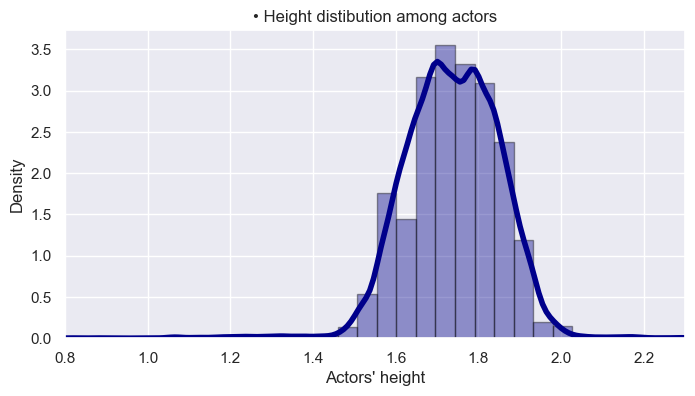

In [231]:
#| echo: false
#| output: false
height_distribution= df_edges_height.drop_duplicates(subset= 'actor1_fbid')['actor_height_x']
plt.subplots(1, 1, figsize=(8, 4))
g1= sns.distplot(height_distribution, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
g1.set_xlabel('Actors\' height')
g1.set_title('• Height distibution among actors')
g1.set(xlim=(0.8, 2.3))

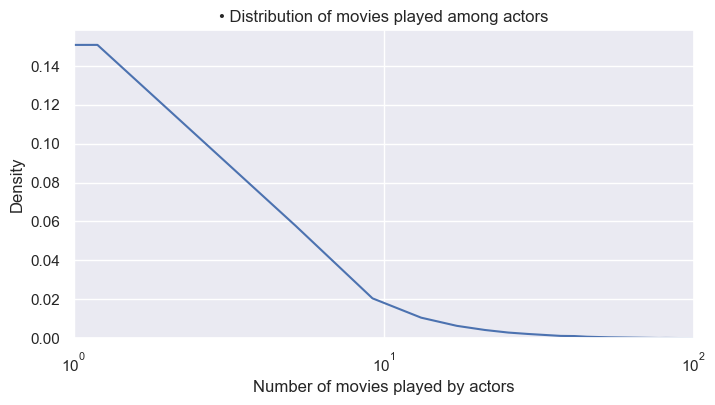

In [230]:
#| echo: false
#| output: false
nbr_movies_distribution= df_edges_nbr_movies.drop_duplicates(subset= 'actor1_fbid')['number_of_movies_x']

plt.subplots(1, 1, figsize=(8, 4))
g2= sns.kdeplot(data=nbr_movies_distribution)
g2.set_xscale('log')
g2.set_xlabel('Number of movies played by actors')
g2.set_title('• Distribution of movies played among actors')
g2.set(xlim=(1, 100))
plt.show()

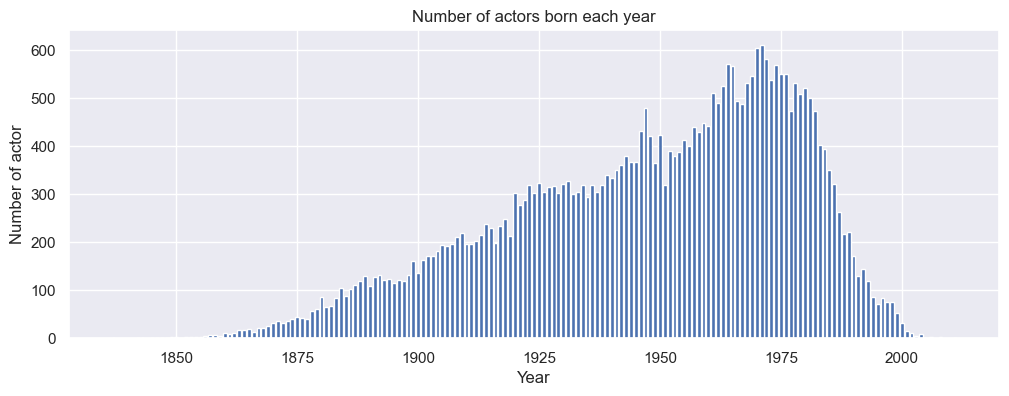

In [228]:
#| echo: false
df_edges_birth_unique= df_edges_birth.drop_duplicates(subset= 'actor1_fbid')
year_counts = {}
for year in df_edges_birth_unique.year_of_birth_x:
    if year not in year_counts:
        year_counts[year] = 1
    else:
        year_counts[year] += 1

# Extract the years and counts as separate lists
years = list(year_counts.keys())
counts = list(year_counts.values())

# Plot the data using matplotlib
plt.subplots(1, 1, figsize=(12, 4))

plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of actor')
plt.title('Number of actors born each year')
plt.show()

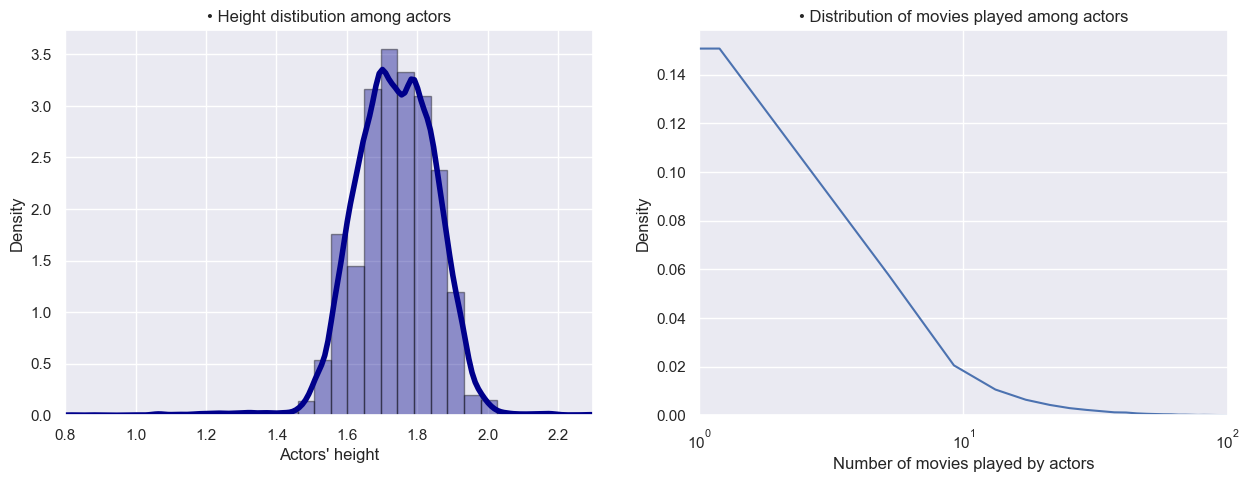

In [172]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

g1= sns.distplot(ax=axes[0], x= height_distribution, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
g1.set_xlabel('Actors\' height')
g1.set_title('• Height distibution among actors')
g1.set(xlim=(0.8, 2.3))

g2= sns.kdeplot(ax=axes[1], data=nbr_movies_distribution)
g2.set_xscale('log')
g2.set_xlabel('Number of movies played by actors')
g2.set_title('• Distribution of movies played among actors')
g2.remove
g2.set(xlim=(1, 100))
plt.show()

Some of these distributions are likely to be gaussian (height) or even a power low distribution for the number of movies played. We can mention that the gender attribute is unbalanced in our dataset and need to be also taken with caution for further interpretations.

We will now pay attention to quantify the homophily score of each actor :
- For categorical attribute, it can be describe as follow : $$Homophily_{i} = \frac{\sum \limits _j \delta_{ij}}{k_i} $$  with $\delta_{ij}$  = 1 if same attribute, else -1 and $ k_i $ is the degree of the node $i$

Therefore, we can calculte the homophily score of each actor. As interpretation, if its value tends to be close to 1, the concerned actor is more likely to play with similar actor. On the other hand, if its value becomes close to -1, it is the opposite case and the actor tends to play with dissimilar actors. [@golub2012network]

Pay attention to the fact that we don't take into account multiple same edges (even though actors played several times with another one, we still consider it as one edge).


- For scalar attribute, we can create a linear equation, meaning that the further the values are apart, the lower the value will be. We illustrated this defintion through the following plot :

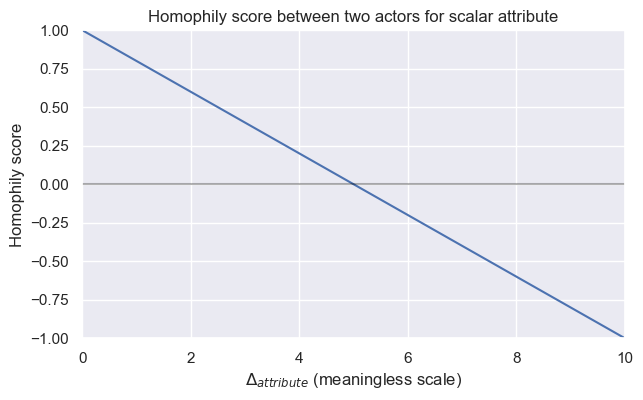

In [233]:
#| echo: false
max_scalar_difference = 10

# Generate a list of positive values for delta x
delta_x_values = list(range(0, max_scalar_difference+1))

# Calculate the corresponding values of y
y_values = [(1 - (2 * (delta_x) / max_scalar_difference)) for delta_x in delta_x_values]

# Plot the values
plt.subplots(1, 1, figsize=(7, 4))
plt.plot(delta_x_values, y_values)

# Add labels and show the plot
#plt.xlabel(r'$\Delta scalar attributes (meaningless scale)')
plt.xlabel(''r'$\Delta_{attribute}$ (meaningless scale)')
plt.xlim(0,10)
plt.axhline(0, color="black", alpha=0.3)
plt.ylim(-1,1)
plt.ylabel('Homophily score')
plt.title('Homophily score between two actors for scalar attribute')
plt.show()

The value for which we consider the homophily score to -1 depends on the standard deviation of the distribution (we target to aim the 95% threshold). $$ \Delta_{max} = 2 \times \sigma $$

- We then compute these homophily scores for each actors in order to vizualise the distribution. We end up with the following distributions according to the different attributes. The four first distributions are the categorical attributes especially with the distribution if the take only the homophily score of men actors (gender men) compared to the case where we take only the homophily score of women actress (gender women). The three next distributions are dedicated to the scalar attributes :

In [174]:
#| echo: false
#| output: false
homophily = {}
df_edges_birth['homophily_age'] = df_edges_birth.apply(lambda x: (1- 2*abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob)) if abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob) < 1 else -1, axis= 1)
age_homophily = df_edges_birth.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
print('mean =',age_homophily.mean(), 'and std =', age_homophily.std())
homophily['age']= {
		'mean': float(age_homophily.mean()),
		'std': float(age_homophily.std())
	}

mean = mean   -0.062216
dtype: float64 and std = mean    0.286545
dtype: float64


In [175]:
#| echo: false
#| output: false
df_edges_height['homophily_height'] = df_edges_height.apply(lambda x: (1- 2*abs(x.actor_height_x-x.actor_height_y)/(2*std_height)) if abs(x.actor_height_x-x.actor_height_y)/(2*std_height) < 1 else -1 , axis= 1)
height_homophily = df_edges_height.groupby('actor1_fbid')['homophily_height'].agg(['mean'])
print('mean =',height_homophily.mean(), 'and std =', height_homophily.std())
homophily['height']= {
		'mean': float(height_homophily.mean()),
		'std': float(height_homophily.std())
	}

mean = mean    0.037047
dtype: float64 and std = mean    0.297658
dtype: float64


In [176]:
#| echo: false
#| output: false
df_edges_gender['same_gender'] = df_edges_gender.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily = df_edges_gender.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily.mean(), 'and std =', gender_homophily.std())
homophily['gender']= {
		'mean': float(gender_homophily.mean()),
		'std': float(gender_homophily.std())
	}

mean = mean    0.120826
dtype: float64 and std = mean    0.405169
dtype: float64


In [177]:
#| echo: false
#| output: false
edges_gender_m = df_edges_merged[df_edges_merged['actor_gender_x'] == 'M']
edges_gender_m= edges_gender_m.dropna(subset=['actor_gender_y'])
edges_gender_m['same_gender'] = edges_gender_m.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_m = edges_gender_m.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print(gender_homophily_m.mean(), gender_homophily_m.std())
homophily['gender_m']= {
		'mean': float(gender_homophily_m.mean()),
		'std': float(gender_homophily_m.std())
	}

mean    0.365263
dtype: float64 mean    0.238025
dtype: float64


In [178]:
#| echo: false
#| output: false
edges_gender_f = df_edges_merged[df_edges_merged['actor_gender_x'] == 'F']
edges_gender_f= edges_gender_f.dropna(subset=['actor_gender_y'])
edges_gender_f['same_gender'] = edges_gender_f.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_f = edges_gender_f.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily_f.mean(), 'and std =', gender_homophily_f.std())
homophily['gender_f']= {
		'mean': float(gender_homophily_f.mean()),
		'std': float(gender_homophily_f.std())
	}

mean = mean   -0.308927
dtype: float64 and std = mean    0.251859
dtype: float64


In [179]:
#| echo: false
#| output: false
df_edges_nat['same_country'] = df_edges_nat.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
country_homophily = df_edges_nat.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',country_homophily.mean(), 'and std =', country_homophily.std())
homophily['country']= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

mean = mean    0.441165
dtype: float64 and std = mean    0.579339
dtype: float64


In [180]:
#| echo: false
#| output: false
df_edges_nbr_movies['same_nbr_movies'] = df_edges_nbr_movies.apply(lambda x: (1- 2*abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies)) if abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies) < 1 else -1, axis= 1)
nbr_movies_homophily = df_edges_nbr_movies.groupby('actor1_fbid')['same_nbr_movies'].agg(['mean'])
print('mean =',nbr_movies_homophily.mean(), 'and std =', nbr_movies_homophily.std())
homophily['nbr_of_movies']= {
		'mean': float(nbr_movies_homophily.mean()),
		'std': float(nbr_movies_homophily.std())
	}

mean = mean    0.25611
dtype: float64 and std = mean    0.418973
dtype: float64


In [181]:
#| echo: false
#| output: false
homophily

{'age': {'mean': -0.062215524241310126, 'std': 0.2865451246303206},
 'height': {'mean': 0.037046725922812475, 'std': 0.29765776694824775},
 'gender': {'mean': 0.12082618928542174, 'std': 0.4051685906973104},
 'gender_m': {'mean': 0.3652634255709688, 'std': 0.23802527529538406},
 'gender_f': {'mean': -0.308926727466187, 'std': 0.25185901038447195},
 'country': {'mean': 0.4411654013013045, 'std': 0.5793386508751193},
 'nbr_of_movies': {'mean': 0.2561099963113205, 'std': 0.4189729616238248}}

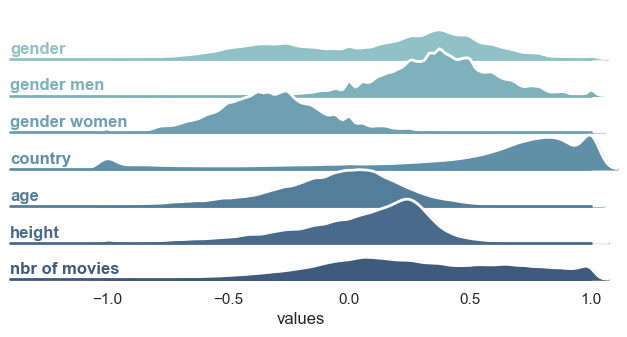

In [182]:
#| echo: false

df_visu = pd.DataFrame({'values':gender_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':age_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':height_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':nbr_movies_homophily['mean']})])
range_idx = [len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily),len(age_homophily),len(height_homophily),len(nbr_movies_homophily)]
name = ['gender','gender men','gender women','country','age','height','nbr of movies']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))
plt.show()


The results are showing some underlying piece of information. Indeed, we see firstly that total gender homophily is mainly driven by two distinguished distributions : the distribution of gender homophily for men and women. Knowing that the dataset contains more men than women, it explains partially that women's homophily has the tendency to be negative in comparison to men's homophily (the "probability" to have a women-men edge is higher than women-women). Moreover, we see that country attribute leads to quite high values of homophily (One first supposition we can make is that movies are more likely to gather actors from the same country, i.e. cluster of countries). Age and height attributes seem quite distributed around the zero (slightly shifted to positive values, thus perhaps a small underliying similarity). Finally, the number of movies played doesn't lead to a direct conclusion as we have a quite flat distribution (we can mention that they are mainly positive values)

In [183]:
#| echo: false
#| output: false
df_visu = pd.DataFrame({'values':gender_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu

,values
actor1_fbid,
/m/010p3,0.348315
/m/010q36,0.600000
/m/010xjr,0.462687
/m/0112yl,0.475113
/m/011_24,0.363636
...,...
/m/0z05l,-0.424000
/m/0z4s,0.005666
/m/0z9q0,-1.000000


In [184]:
#| echo: false
#| output: false
df_visu2 = pd.DataFrame({'values':age_homophily['mean']})
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':height_homophily['mean']})])
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':nbr_movies_homophily['mean']})])
df_visu2

,values
actor1_fbid,
/m/010p3,0.280712
/m/010q36,-0.632134
/m/010xjr,-0.219142
/m/0112yl,-0.026698
/m/011_24,0.365655
...,...
/m/0z05l,-0.498495
/m/0z4s,-0.955392
/m/0z9q0,0.411110


In [185]:
#| echo: false
#| output: false
range_idx = [len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily)]
name = ['gender','gender_m','gender_f','country']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)
range_idx = [len(age_homophily),len(height_homophily),len(nbr_movies_homophily)]
name = ['age','height','nbr_movies_played']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu2['name']= idx
df_visu2= df_visu2.reset_index(drop=True)
df_visu,df_visu2

(          values     name
 0       0.348315   gender
 1       0.600000   gender
 2       0.462687   gender
 3       0.475113   gender
 4       0.363636   gender
 ...          ...      ...
 137078 -0.424000  country
 137079  0.005666  country
 137080 -1.000000  country
 137081  0.931034  country
 137082  0.506849  country
 
 [137083 rows x 2 columns],
           values               name
 0       0.280712                age
 1      -0.632134                age
 2      -0.219142                age
 3      -0.026698                age
 4       0.365655                age
 ...          ...                ...
 104365 -0.498495  nbr_movies_played
 104366 -0.955392  nbr_movies_played
 104367  0.411110  nbr_movies_played
 104368  0.019013  nbr_movies_played
 104369 -0.788681  nbr_movies_played
 
 [104370 rows x 2 columns])

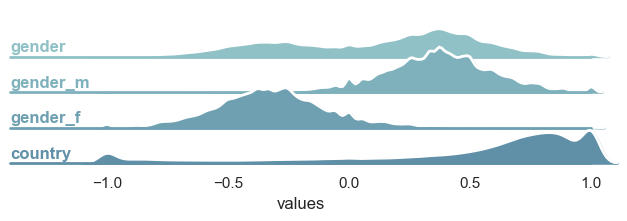

In [186]:
#| echo: false
#| output: false
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))

plt.show()

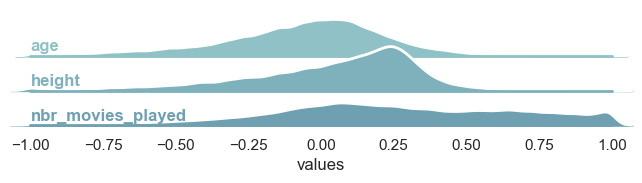

In [187]:
#| echo: false
#| output: false
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu2, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1, 1))

plt.show()

## Comparison part

The raw distribution we gathered above could be not relevant and could lead to wrong interpretation because the dataset is not equally balanced among all attributes (for example the gender distribution). Therefore, if we want to make better observations, we need to compare it with what we expected to see for random edges between actors. We worked on two different possibility for the comparison that we will present to you below.

### Comparison with "mean actor" of the dataset

The first idea is to think about probabilities. For categorical attributes, we can calculate the probability for an actor to randomly be assigned to this attribute knowing the initial distribution over the dataset. Therefore, we decided to create a "mean actor" which is the hypothetical actor that we could get randomly. Each actor of the dataset will be linked to this mean actor and their associated homophily score shall be detailled as followed :
$$  Homophily_{i} = p_{attribute} - (1- p_{attribute}) $$ 
with $ p_{attribute} $ being the probability that "mean actor" have the same attribute as the actor $i$.

In [188]:
#| echo: false
#| output: false
df_gender_reduced = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
nbr_of_men = len(df_gender_reduced[df_gender_reduced['actor_gender_x'] == 'M'])
nbr_of_women = len(df_gender_reduced) - nbr_of_men
hypothetical_gender_homophily_score = (nbr_of_men*((nbr_of_men-1)+ (-1)*nbr_of_women))/(len(df_gender_reduced)-1) + (nbr_of_women*((nbr_of_women-1)+ (-1)*nbr_of_men))/(len(df_gender_reduced)-1)
hypothetical_gender_homophily= hypothetical_gender_homophily_score/len(df_gender_reduced)
hypothetical_gender_homophily


0.07553615796911524

In [189]:
#| echo: false
#| output: false
df_edges_nat_reduced = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
xy = df_edges_nat_reduced.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
total_actor= xy.sum()
homophily_score=0
for i in xy.iloc:
    homophily_score+= (int(i)*(int(i)-1)+(-1)*(total_actor-int(i)))/(total_actor-1)
hypo_homophily_country = homophily_score/total_actor
hypo_homophily_country

count    0.213315
dtype: float64

In [190]:
#| echo: false
#| output: false
df_actor_with_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_nationality_x']]
df_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
nbr_per_country = df_nat.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_country.index),'probability': list(nbr_per_country['count'].apply(lambda x: x/nbr_per_country.sum())['count'])})
probabilties


,country,probability
0,Albania,0.000085
1,Algeria,0.000141
2,Argentina,0.006394
3,Armenia,0.000028
4,Australia,0.019915
...,...,...
142,Weimar Republic,0.000141
143,West Bengal,0.000028
144,West Germany,0.000056
145,Yugoslavia,0.000085


In [191]:
#| echo: false
#| output: false
l =[]
for i in df_actor_with_nat.actor_nationality_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_nat['homophily_nat_mean_actor']= l

In [192]:
#| echo: false
#| output: false
df_visu_compare= pd.DataFrame({"homophily score nationalities":country_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score nationalities":df_actor_with_nat['homophily_nat_mean_actor']})])
range_idx = [len(country_homophily),len(df_actor_with_nat)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
df_visu_compare

,homophily score nationalities,subset
0,0.761905,true edges
1,0.600000,true edges
2,-0.923077,true edges
3,0.065421,true edges
4,0.593103,true edges
...,...,...
70997,-0.997747,edges with mean actor
70998,-0.997747,edges with mean actor
70999,-0.990930,edges with mean actor
71000,-0.998592,edges with mean actor


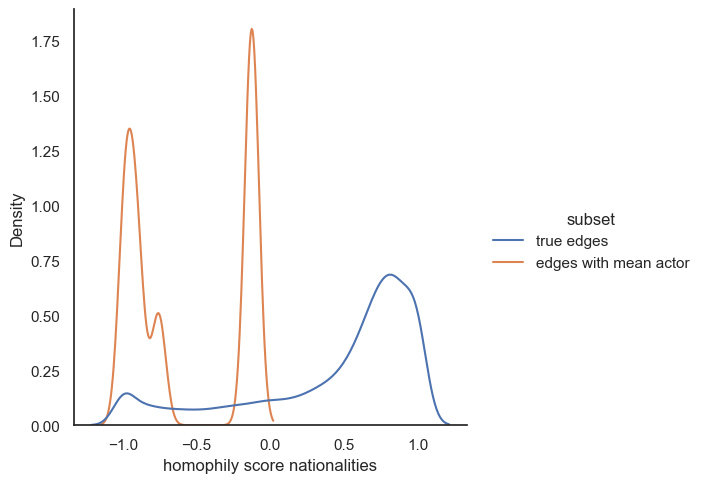

In [193]:
#| echo: false
sns.displot(data=df_visu_compare, x="homophily score nationalities", hue="subset", kind="kde")
plt.show()

In [194]:
#| echo: false
df_actor_with_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_gender_x']]
nbr_per_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid').groupby('actor_gender_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_gender.index),'probability': list(nbr_per_gender['count'].apply(lambda x: x/nbr_per_gender.sum())['count'])})
l =[]
for i in df_actor_with_gender.actor_gender_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_gender['homophily_gender_mean_actor']= l


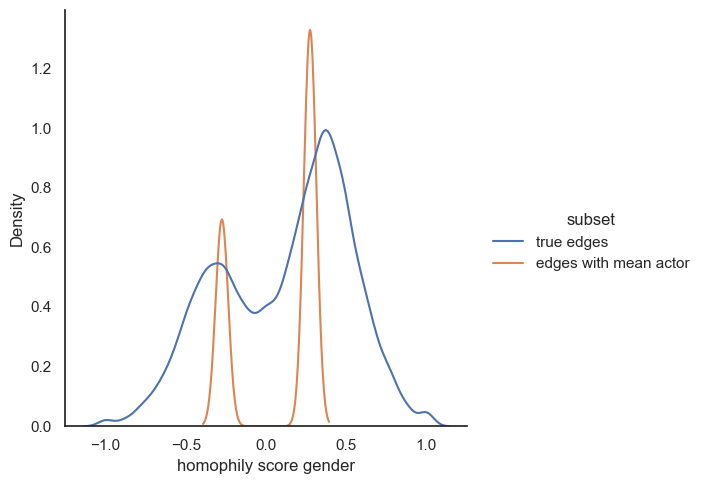

In [195]:
#| echo: false
df_visu_compare= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":df_actor_with_gender['homophily_gender_mean_actor'][0:int(len(df_actor_with_gender)/4)]})])
range_idx = [len(gender_homophily),int(len(df_actor_with_gender)/4)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
sns.displot(data=df_visu_compare, x="homophily score gender", hue="subset", kind="kde")
plt.show()

As first comparison observation, nationaties seems to be an attribute relevant for similarity in actor connections. On the other hand, we can't get much information from gender comparison except that homophily score for men is slightly higher than the random case and oppositely women actress tends to have lower homophily score in the true dataset compared to the "mean" case.

### Edges randomization for comparison

The second option for comparison is the randomize the edges [@La_Fond_Randomization]. We keep the degree of each actor, but instead of their true links, each edge will be repaced by an edge with a random actor in the dataset. With that, we can once again compute their homophily score. The advantage here is that we obtain a distribution that could be compared to the raw distributions we obtained earlier (and we can also perfom it on scalar attribute comapared to the "mean actor") 

In [196]:
#| echo: false
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return u_statistic, p_value

In [197]:
#| echo: false
df_edges_random = df_edges.copy()
df_edges_random['actor2_fbid']= sample(list(df_edges['actor2_fbid']),len(df_edges))
df_edges_merged_random= df_edges_random.merge(df_actors_reduced, on='actor1_fbid').merge(df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"}), on='actor2_fbid')

In [198]:
#| echo: false
df_edges_gender_rdm=df_edges_merged_random.dropna(subset=['actor_gender_x'])
df_edges_gender_rdm=df_edges_gender_rdm.dropna(subset=['actor_gender_y'])

df_edges_age_rdm=df_edges_merged_random.dropna(subset=['actor_age_x'])
df_edges_age_rdm=df_edges_age_rdm.dropna(subset=['actor_age_y'])
std_age = df_edges_gender_rdm.apply(lambda x : abs(x.actor_age_x),axis=1).std()

df_edges_gender_rdm=df_edges_merged_random.dropna(subset=['actor_gender_x'])
df_edges_gender_rdm=df_edges_gender_rdm.dropna(subset=['actor_gender_y'])

df_edges_nat_rdm=df_edges_merged_random.dropna(subset=['actor_nationality_x'])
df_edges_nat_rdm=df_edges_nat_rdm.dropna(subset=['actor_nationality_y'])

df_edges_birth_rdm=df_edges_merged_random.dropna(subset=['year_of_birth_x'])
df_edges_birth_rdm=df_edges_birth_rdm.dropna(subset=['year_of_birth_y'])
df_edges_birth_rdm= df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_x'] < 2022]
df_edges_birth_rdm= df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_y'] < 2022]
df_edges_birth_rdm=df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_x']>1800]
df_edges_birth_rdm=df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_y']>1800]
std_yob = df_edges_birth_rdm.apply(lambda x : abs(x.year_of_birth_x-x.year_of_birth_y),axis=1).std()

edges_height_rdm=df_edges_merged_random.dropna(subset=['actor_height_x'])
edges_height_rdm= edges_height_rdm.dropna(subset=['actor_height_y'])
edges_height_rdm=edges_height_rdm[edges_height_rdm['actor_height_x']<3]
edges_height_rdm=edges_height_rdm[edges_height_rdm['actor_height_y']<3]
std_height = edges_height_rdm.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.actor_height_x),axis=1).std()

edges_nbr_movies_rdm=df_edges_merged_random.dropna(subset=['number_of_movies_x'])
edges_nbr_movies_rdm= edges_nbr_movies_rdm.dropna(subset=['number_of_movies_y'])
std_nbr_movies = edges_nbr_movies_rdm.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.number_of_movies_x),axis=1).std()

In [199]:
#| echo: false
#| output: false
df_edges_gender_rdm['same_gender'] = df_edges_gender_rdm.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_rdm = df_edges_gender_rdm.groupby('actor1_fbid')['same_gender'].agg(['mean'])
df_visu_compare1= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare1= pd.concat([df_visu_compare1, pd.DataFrame({"homophily score gender":gender_homophily_rdm['mean']})])
range_idx = [len(gender_homophily),len(gender_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare1['subset']= idx
df_visu_compare1= df_visu_compare1.reset_index(drop=True)

In [200]:
#| echo: false
#| output: false
p_values =[]
p_values.append(mann_whitney_u_test(list(gender_homophily['mean']), list(gender_homophily_rdm['mean']))[1])

In [201]:
#| echo: false
#| output: false
df_edges_nat_rdm['same_nat'] = df_edges_nat_rdm.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
nat_homophily_rdm = df_edges_nat_rdm.groupby('actor1_fbid')['same_nat'].agg(['mean'])
df_visu_compare2= pd.DataFrame({"homophily score nationalities":country_homophily['mean']})
df_visu_compare2= pd.concat([df_visu_compare2, pd.DataFrame({"homophily score nationalities":nat_homophily_rdm['mean']})])
range_idx = [len(country_homophily),len(nat_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare2['subset']= idx
df_visu_compare2= df_visu_compare2.reset_index(drop=True)

In [202]:
#| echo: false
#| output: false
p_values.append(mann_whitney_u_test(list(country_homophily['mean']), list(gender_homophily_rdm['mean']))[1])

In [203]:
#| echo: false
#| output: false
df_edges_birth_rdm = df_edges_birth_rdm[df_edges_birth_rdm.apply(lambda x: True if abs(x.year_of_birth_x - x.year_of_birth_y) < 90 else False, axis= 1)]
df_edges_birth_rdm['homophily_age'] = df_edges_birth_rdm.apply(lambda x: (1- 2*abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob)) if abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob) < 1 else -1, axis= 1)
age_homophily_rdm = df_edges_birth_rdm.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
df_visu_compare3= pd.DataFrame({"homophily age":age_homophily['mean']})
df_visu_compare3= pd.concat([df_visu_compare3, pd.DataFrame({"homophily age":age_homophily_rdm['mean']})])
range_idx = [len(age_homophily),len(age_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare3['subset']= idx
df_visu_compare3= df_visu_compare3.reset_index(drop=True)

In [204]:
#| echo: false
#| output: false
p_values.append(mann_whitney_u_test(list(age_homophily['mean']), list(age_homophily_rdm['mean']))[1])

In [205]:
#| echo: false
#| output: false
edges_height_rdm['homophily_height'] = edges_height_rdm.apply(lambda x: (1- 2*abs(x.actor_height_x-x.actor_height_y)/(2*std_height)) if abs(x.actor_height_x-x.actor_height_y)/(2*std_height) < 1 else -1 , axis= 1)
height_homophily_rdm = edges_height_rdm.groupby('actor1_fbid')['homophily_height'].agg(['mean'])
df_visu_compare4= pd.DataFrame({"homophily height":height_homophily['mean']})
df_visu_compare4= pd.concat([df_visu_compare4, pd.DataFrame({"homophily height":height_homophily_rdm['mean']})])
range_idx = [len(height_homophily),len(height_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare4['subset']= idx
df_visu_compare4= df_visu_compare4.reset_index(drop=True)

In [206]:
#| echo: false
#| output: false
p_values.append(mann_whitney_u_test(list(height_homophily['mean']), list(height_homophily_rdm['mean']))[1])

In [207]:
#| echo: false
#| output: false
edges_nbr_movies_rdm['same_nbr_movies'] = edges_nbr_movies_rdm.apply(lambda x: (1- 2*abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies)) if abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies) < 1 else -1, axis= 1)
nbr_movies_homophily_rdm = edges_nbr_movies_rdm.groupby('actor1_fbid')['same_nbr_movies'].agg(['mean'])
df_visu_compare5= pd.DataFrame({"same nbr movies":nbr_movies_homophily['mean']})
df_visu_compare5= pd.concat([df_visu_compare5, pd.DataFrame({"same nbr movies":nbr_movies_homophily_rdm['mean']})])
range_idx = [len(nbr_movies_homophily),len(nbr_movies_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare5['subset']= idx
df_visu_compare5= df_visu_compare5.reset_index(drop=True)

In [208]:
#| echo: false
#| output: false
p_values.append(mann_whitney_u_test(list(nbr_movies_homophily['mean']), list(nbr_movies_homophily_rdm['mean']))[1])

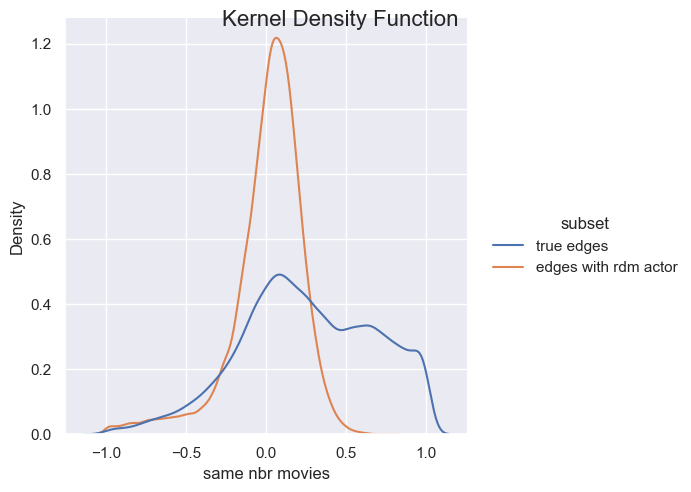

In [209]:
#| echo: false
sns.set(rc = {'figure.figsize':(15,8)})
g = sns.displot(data=df_visu_compare5, x='same nbr movies', hue="subset", kind="kde")
g.fig.suptitle("Kernel Density Function", fontsize=16)

plt.show()

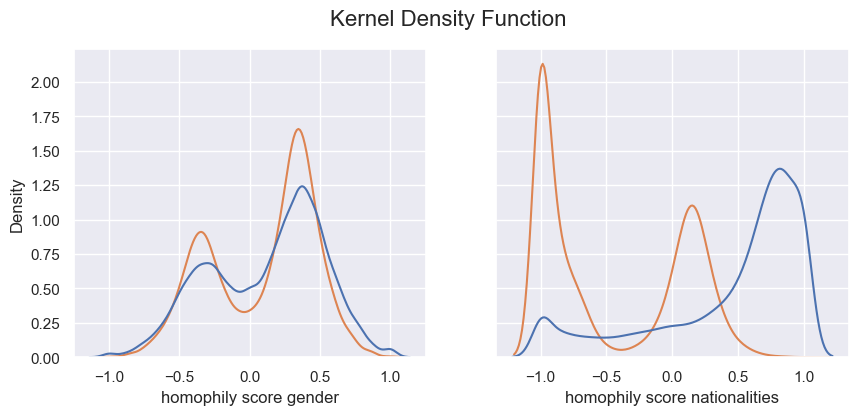

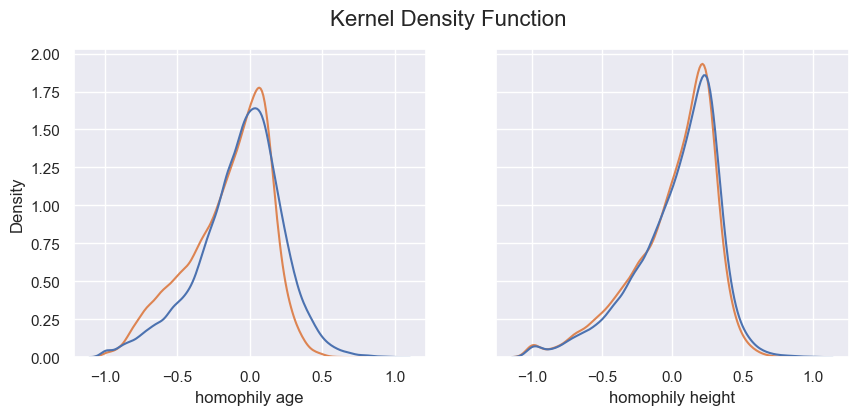

In [210]:
#| echo: false
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey= True)

sns.kdeplot(ax= axs[0],x='homophily score gender', data=df_visu_compare1, hue='subset', common_norm=False, legend= False)
sns.kdeplot(ax= axs[1],x='homophily score nationalities', data=df_visu_compare2, hue='subset', common_norm=False, legend= False)

fig.suptitle("Kernel Density Function", fontsize=16)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey= True)

sns.kdeplot(ax= axs[0],x='homophily age', data=df_visu_compare3, hue='subset', common_norm=False, legend= False)
sns.kdeplot(ax = axs[1],x='homophily height', data=df_visu_compare4, hue='subset', common_norm=False, legend= False)
fig.suptitle("Kernel Density Function", fontsize=16)
plt.show()

- p_value for the mann_whitney_u_test on the distributions :

In [211]:
#| echo: false
attribute = ['number of movies', 'gender', 'nationalities', 'age', 'height']
pd.DataFrame({'attribute': attribute, 'p-values':p_values})

,attribute,p-values
0,number of movies,2.461082e-31
1,gender,0.000000e+00
2,nationalities,1.803844e-255
3,age,3.805015e-09
4,height,0.000000e+00


Based on the results illustrated above, we can make different conclusions. Firstly, we obtained more or less the same interpretation for the categorical attributes. It seems like actors from a certain country are more quite likely to play together (we can think about cinemar studios as hollywood, bollyhood, ...). Moreover, the age of the actor looks like this is not a relevant attribute to link actor in movies. The only observation we can made is that the true edges are slightly shifted to the left meaning that is decrease the total homophily of the network compared to the random edges.
Furthermore, even though gender initialy seems to be significant for similarity, it appears that on our dataset, it is not a relevant attribute that connect more actor (We can think about a certain diversity of gender in the movies. Maybe in a further analysis, we could have a look on how this homophily evolve depending on the movie's genre). Finaly, height is not a significant attribute to connect people as we can see in the plot above, especially because we obtain the same distribution either with random edges and the true edges.

In [212]:
# NetworkX Research, not relevant for the web story
#| echo: false
import networkx as nx

In [213]:
#| echo: false
#| output: false
df_edges_nat.drop_duplicates(subset= 'actor1_fbid').groupby('actor_nationality_x')['actor_nationality_x'].agg(['count']).sort_values(by='count', ascending= False).head(10)

,count
actor_nationality_x,
United States of America,15534
United Kingdom,4305
India,1987
France,1647
Canada,1622
Japan,1285
Germany,860
Australia,707
Italy,575


In [214]:
#| echo: false
#| output: false
df_edges_grouped= df_edges_merged[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 57694 nodes and 1518297 edges


In [215]:
#| echo: false
#| output: false
x = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_gender_x']))
nx.set_node_attributes(g, name = "actor_gender_x", 
values = class_attr)

In [216]:
#| echo: false
#| output: false
nx.attribute_assortativity_coefficient(g, "actor_gender_x")

0.06115305599700355

In [217]:
#| echo: false
#| output: false
df_edges_grouped= df_edges_merged[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 57694 nodes and 1518297 edges


In [218]:
#| echo: false
#| output: false
x = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_nationality_x']))
nx.set_node_attributes(g, name = "actor_nationality_x", 
values = class_attr)

In [219]:
#| echo: false
#| output: false
nx.attribute_assortativity_coefficient(g, "actor_nationality_x")

0.43548634030680133